# Web Traffic Time Series Forecasting
### Part3: Topic Clustering (K-means)


In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
import string
import re
import mpld3
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt

In [2]:
train_new=pd.read_csv('train_EDA.csv')
topic_en=train_new[train_new['lang'] == 'en']['topic'].unique()

In [3]:
print('Total Unique English Topics {}'.format(len(topic_en)))

Total Unique English Topics 11048


In [4]:
from nltk.stem.wordnet import WordNetLemmatizer
stopwords_en = stopwords.words('english')
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [5]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    clean = re.sub("\W|_", " ", mess).lower()
    nopunc = ([char for char in clean \
               if char not in string.punctuation and not char.isdigit()])
    nopunc = ''.join(nopunc)
    
    new_word = [word for word in nopunc.split() if word not in stopwords_en]
    new_word = [stemmer.stem(w) for w in new_word]
    new_word = [lemma.lemmatize(w) for w in new_word]
    return new_word

In [6]:
vect = TfidfVectorizer(analyzer=text_process,max_df=0.2, min_df=1)

%time topic_en_vect = vect.fit_transform(topic_en) #fit the vectorizer to synopses

len(vect.vocabulary_)

CPU times: user 2.47 s, sys: 31.8 ms, total: 2.5 s
Wall time: 2.5 s


11925

In [7]:
#print(topic_en_vect.shape)
# reduce dimensions
#svd = TruncatedSVD(n_components=5, random_state = 0)
#X_2d = svd.fit_transform(topic_en_vect)

In [8]:
from sklearn.cluster import KMeans
num_clusters = 4
km = KMeans(n_clusters=num_clusters,max_iter=100,n_init=60,init='k-means++')
topic_clustered = km.fit_predict(topic_en_vect)

In [9]:
frame = pd.DataFrame(topic_en, index = [topic_clustered] , columns = ['title'])
frame.index.value_counts()

(0,)    10182
(2,)      566
(1,)      182
(3,)      118
dtype: int64

In [10]:
frame=frame.reset_index()

In [11]:
sample_en = []
for i in range(0,num_clusters):
    #print(i)
    count = 0
    for j in range(0,len(frame)):
        if frame['level_0'][j] == i and count <=10:
            #print(j)
            sample_en.append(frame['title'][j])
            count=count+1
            #print(count)
        

In [12]:
sample_en_vect = vect.transform(sample_en)
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(sample_en_vect)

In [13]:
km.cluster_centers_.shape
km.inertia_ 

10892.472279583944

In [14]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(num_clusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 state
 olymp
 unit
 summer
 john
Cluster 1:
 seri
 tv
 u
 war
 naagin
Cluster 2:
 film
 list
 episod
 countri
 state
Cluster 3:
 footbal
 team
 nation
 american
 championship


In [15]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

#set up cluster names using a dict
cluster_names = {3: 'john, season, episod', 
                 0: 'film, olymp, summer,', 
                 2: 'state, unit, elect', 
                 1: 'seri, tv, world'}

### PLOT  (only the sample data) 

In [16]:
from sklearn.manifold import MDS
MDS()
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [17]:
#define custom toolbar location

class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [18]:
topic_clustered_sample = km.predict(sample_en_vect)
topic_clustered_sample

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int32)

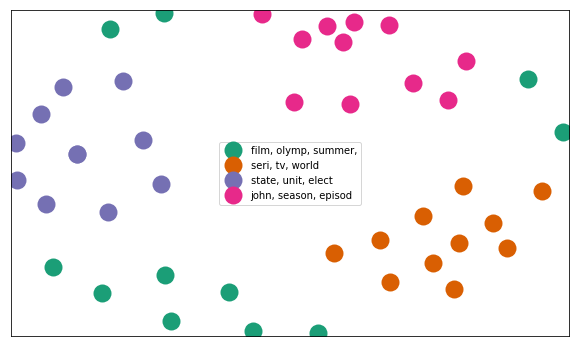

In [21]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=topic_clustered_sample, title=sample_en)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -50px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(10,6)) #set plot size
ax.margins(0.01) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=5, hoffset=5, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

#mpld3.display() #show the plot

#uncomment the below to export to html
html = mpld3.fig_to_html(fig)
#print(html)